Model: Logistic Regression & TF - IDF

1. Import các thư viện cần thiết

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Thiết lập style cho biểu đồ
plt.style.use('seaborn')
sns.set(font_scale=1.2)

/tmp/ipykernel_9135/1476599897.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


2. Đọc và khám phá dữ liệu

Kích thước dữ liệu: (10572, 2)

5 dòng đầu tiên:


,message,category
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,junk
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham



Phân phối các lớp:
category
ham     7828
junk    2744
Name: count, dtype: int64


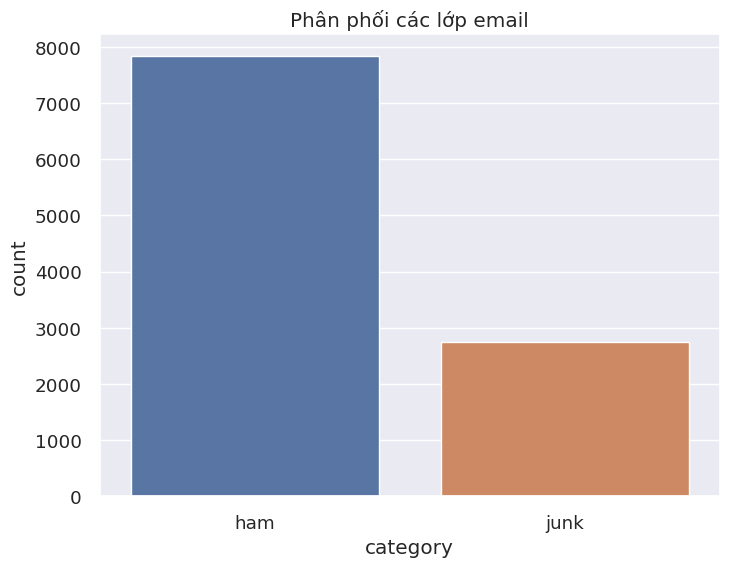

In [8]:
# Đọc dữ liệu
df = pd.read_csv('../resource/email_data.csv')

# Hiển thị thông tin cơ bản về dữ liệu
print("Kích thước dữ liệu:", df.shape)
print("\n5 dòng đầu tiên:")
display(df.head())

# Thống kê phân phối các lớp
print("\nPhân phối các lớp:")
print(df['category'].value_counts())

# Vẽ biểu đồ phân phối
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='category')
plt.title('Phân phối các lớp email')
plt.show()

3. Tiền xử lý dữ liệu

In [9]:
# Chuyển đổi nhãn thành số
df['category'] = df['category'].map({'ham': 0, 'junk': 1})

# Kiểm tra kết quả\n",
print("Phân phối sau khi chuyển đổi:")
print(df['category'].value_counts())

Phân phối sau khi chuyển đổi:
category
0    7828
1    2744
Name: count, dtype: int64


4. Trích xuất đặc trưng TF-IDF

In [10]:
# Handle: Thay thế giá trị NaN bằng chuỗi rỗng
df['message'] = df['message'].fillna('')

# Khởi tạo vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,  # Giới hạn số lượng từ
    stop_words='english',  # Loại bỏ stop words
    ngram_range=(1, 2)  # Xét cả unigram và bigram
)

# Trích xuất đặc trưng
X = vectorizer.fit_transform(df['message'])
y = df['category']

print("Kích thước ma trận đặc trưng:", X.shape)
print("Số lượng từ vựng:", len(vectorizer.get_feature_names_out()))

Kích thước ma trận đặc trưng: (10572, 5000)
Số lượng từ vựng: 5000


5. Chia tập dữ liệu và huấn luyện mô hình

In [12]:
# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Kích thước tập train:", X_train.shape)
print("Kích thước tập test:", X_test.shape)

# Huấn luyện mô hình
model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs'
)

model.fit(X_train, y_train)

Kích thước tập train: (8457, 5000)
Kích thước tập test: (2115, 5000)


LogisticRegression(max_iter=1000)

6. Đánh giá mô hình

Accuracy: 0.9361702127659575

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1566
           1       0.96      0.79      0.86       549

    accuracy                           0.94      2115
   macro avg       0.95      0.89      0.91      2115
weighted avg       0.94      0.94      0.93      2115



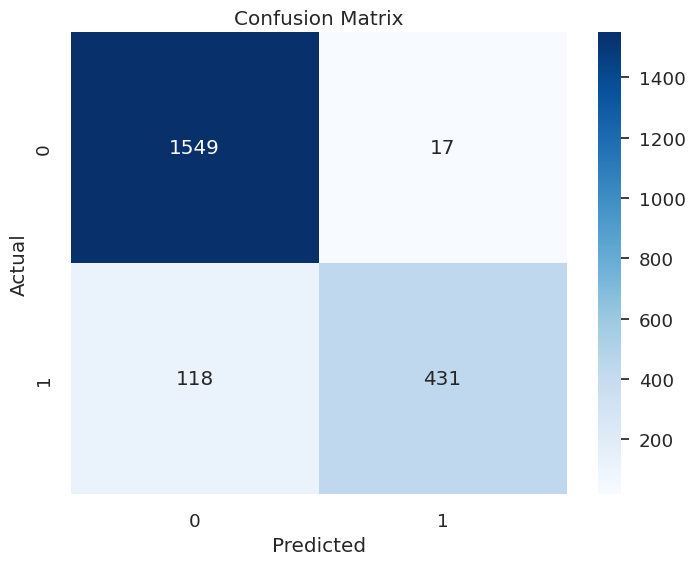

In [13]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# In kết quả đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

7. Lưu mô hình và vectorizer

In [14]:
# Lưu mô hình và vectorizer
joblib.dump(model, 'email_classifier.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

print("Mô hình và vectorizer đã được lưu thành công!")

Mô hình và vectorizer đã được lưu thành công!


8. Thử nghiệm với email mới

In [16]:
def predict_email(email_text):
    # load mô hình và vectorizer
    model = joblib.load('email_classifier.joblib')
    vectorizer = joblib.load('tfidf_vectorizer.joblib')
    
    # chuyển email thành vector
    email_vector = vectorizer.transform([email_text])
    
    # dự đoán
    prediction = model.predict(email_vector)[0]
    probability = model.predict_proba(email_vector)[0]

    # print kết quả
    result = "ham" if prediction == 0 else "junk"
    print(f"Email được phân loại là: {result}")
    print(f"Xác suất ham: {probability[0]:.2f}")
    print(f"Xác suất junk: {probability[1]:.2f}")
    
    return result

# thử nghiệm 
test_email = """
Dear valued customer,
We are pleased to inform you about our new product launch.
Please visit our website for more information.
Best regards,
Company Team
"""

predict_email(test_email)

Email được phân loại là: junk
Xác suất ham: 0.14
Xác suất junk: 0.86


'junk'